# Titanic

In [1]:
%matplotlib inline

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

##Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

##Settings
pd.options.display.max_rows = 20
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [66]:
def plot(features):
    d={}
    for f in features:
        temp=df.groupby(["Survived",f]).size()
        d[f]=pd.concat([temp[0],temp[1]],axis=1).fillna(0)
    for f in features:
        plt.bar(np.arange(len(d[f][1])),d[f][1],bottom=d[f][0],label="Survived",color="g")
        plt.bar(np.arange(len(d[f][0])),d[f][0],label="Not survived",color="r")
        plt.xticks(np.arange(len(d[f][0])),d[f].index.values,rotation=90)
        plt.ylabel("Number of people")
        plt.title(f)
        plt.legend()
        plt.show()   
    

### Loading and check data

In [33]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
trainId=train["PassengerId"]
testId=test["PassengerId"]
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [34]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.000,NaN,S,7.250,"Braund, Mr. Owen Harris",0,1,3,male,1,0.000,A/5 21171
1,38.000,C85,C,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.000,PC 17599
2,26.000,NaN,S,7.925,"Heikkinen, Miss. Laina",0,3,3,female,0,1.000,STON/O2. 3101282
3,35.000,C123,S,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.000,113803
4,35.000,NaN,S,8.050,"Allen, Mr. William Henry",0,5,3,male,0,0.000,373450


In [35]:
df.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,nan,NaN,S,8.050,"Spector, Mr. Woolf",0,1305,3,male,0,nan,A.5. 3236
1305,39.000,C105,C,108.900,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,nan,PC 17758
1306,38.500,NaN,S,7.250,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,nan,SOTON/O.Q. 3101262
1307,nan,NaN,S,8.050,"Ware, Mr. Frederick",0,1308,3,male,0,nan,359309
1308,nan,NaN,C,22.358,"Peter, Master. Michael J",1,1309,3,male,1,nan,2668


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [37]:
df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000,1308.000,1309.000,1309.000,1309.000,1309.000,891.000
mean,29.881,33.295,0.385,655.000,2.295,0.499,0.384
std,14.413,51.759,0.866,378.020,0.838,1.042,0.487
min,0.170,0.000,0.000,1.000,1.000,0.000,0.000
25%,21.000,7.896,0.000,328.000,2.000,0.000,0.000
50%,28.000,14.454,0.000,655.000,3.000,0.000,0.000
75%,39.000,31.275,0.000,982.000,3.000,1.000,1.000
max,80.000,512.329,9.000,1309.000,3.000,8.000,1.000


In [38]:
df.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343
freq,6,914,2,843,11


In [39]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [40]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000,418.000,332.000,418.000,418.000,417.000
mean,1100.500,2.266,30.273,0.447,0.392,35.627
std,120.810,0.842,14.181,0.897,0.981,55.908
min,892.000,1.000,0.170,0.000,0.000,0.000
25%,996.250,1.000,21.000,0.000,0.000,7.896
50%,1100.500,3.000,27.000,0.000,0.000,14.454
75%,1204.750,3.000,39.000,1.000,0.000,31.500
max,1309.000,3.000,76.000,8.000,9.000,512.329


In [41]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Knight, Mr. Robert J",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


In [42]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Linehan, Mr. Michael",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


### Feature analysis

In [43]:
df["Sex"]=df["Sex"].map({"male":1,"female":0,1:1,0:0}).values

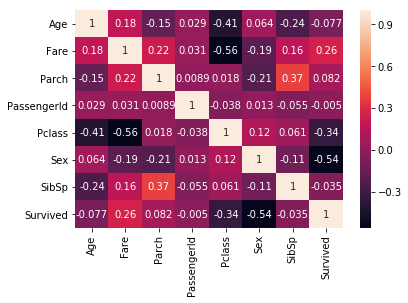

In [44]:
sns.heatmap(df.corr(),annot=True);plt.show()

In [45]:
temp=df.groupby("Survived").size()
temp

Survived
0.000    549
1.000    342
dtype: int64

In [46]:
'{:.2f}'.format(temp[1]/float(temp[0]+temp[1]))

'0.38'

#### Sex

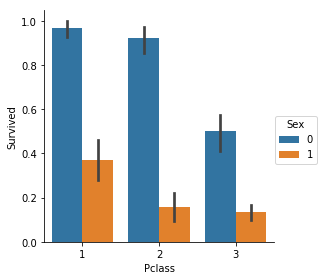

In [47]:
sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=df,kind="bar")

In [245]:
df["PSex"]=2*df["Pclass"]-1+df["Sex"]

#### Pclass

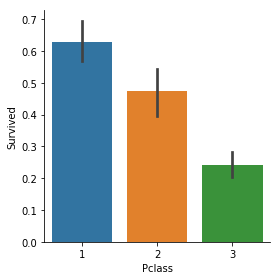

In [48]:
sns.factorplot(x="Pclass",y="Survived",data=df,kind="bar")

#### Fare

Only one missing value

In [49]:
df["Fare"]=df["Fare"].fillna(df["Fare"].median())

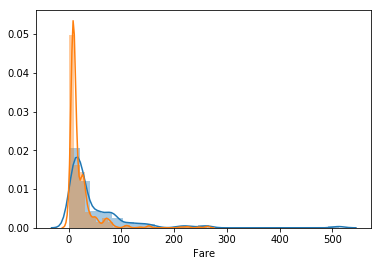

In [50]:
sns.distplot(df["Fare"][df["Survived"]==1],bins=25)
sns.distplot(df["Fare"][df["Survived"]==0],bins=25)

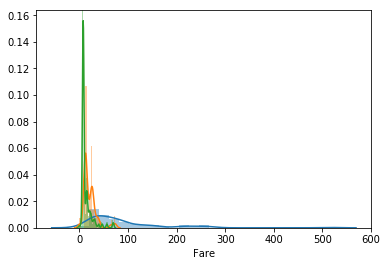

In [51]:
sns.distplot(df["Fare"][df["Pclass"]==1],bins=25)
sns.distplot(df["Fare"][df["Pclass"]==2],bins=25)
sns.distplot(df["Fare"][df["Pclass"]==3],bins=25)

In [52]:
df["LFare"]=df["Fare"].apply(lambda x: math.log(x+1))

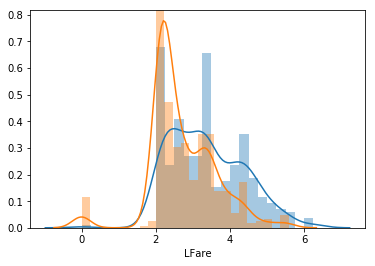

In [53]:
sns.distplot(df["LFare"][df["Survived"]==1],bins=25)
sns.distplot(df["LFare"][df["Survived"]==0],bins=25)

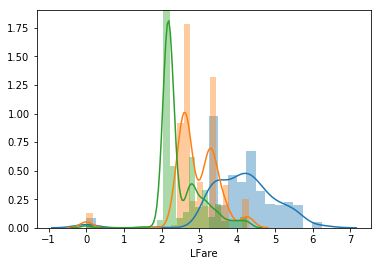

In [54]:
sns.distplot(df["LFare"][df["Pclass"]==1],bins=25)
sns.distplot(df["LFare"][df["Pclass"]==2],bins=25)
sns.distplot(df["LFare"][df["Pclass"]==3],bins=25)

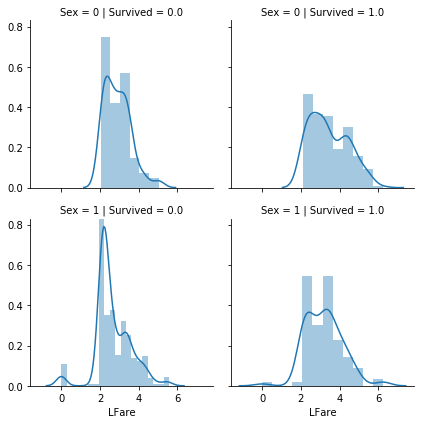

In [57]:
sns.FacetGrid(df,row="Sex",col="Survived").map(sns.distplot,"LFare")


In [58]:
df["rLFare"]=pd.cut(df["LFare"],[0,3,4,5,8],labels=[1,2,3,4])

In [59]:
pd.crosstab(df["Survived"],df["rLFare"])

rLFare,1,2,3,4
Survived,,,,
0.000,356,34,136,9
1.000,136,78,107,20


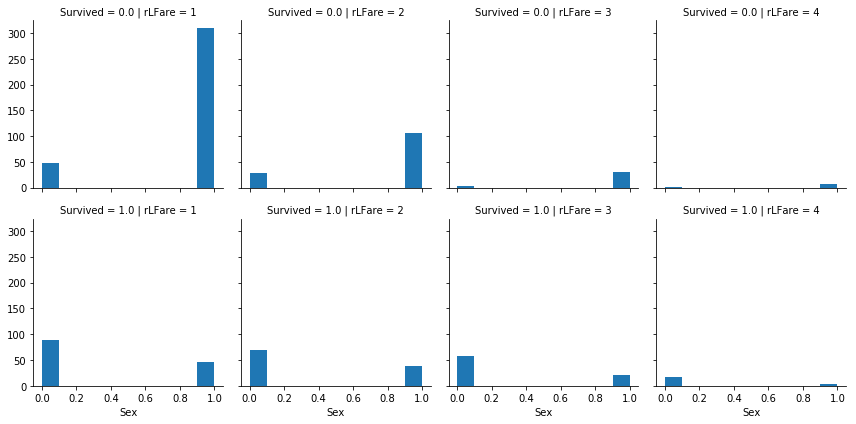

In [64]:
sns.FacetGrid(df,col="rLFare",row="Survived").map(plt.hist,"Sex")

#### What we learn:
- Paying higher fare or being on a higher pclass increass odds of survival. For women as well men. 
- However main predictor is your sex. Even you paid a lot of Fare your odds as a man are still low to survive. 
- For women: even if you paid low fare your odds of survival are large. 
- Paying low fare is very much correlated with sex. 

#### Age

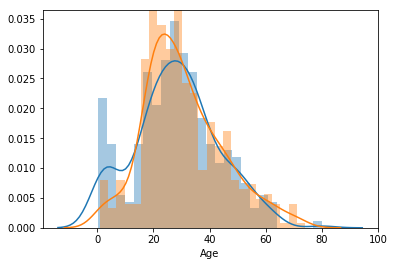

In [22]:
sns.distplot(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=25)
sns.distplot(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=25)

In [153]:
df["Age"].describe()

count   1309.000
mean      29.178
std       13.274
min        0.170
25%       22.000
50%       26.000
75%       37.000
max       80.000
Name: Age, dtype: float64

In [76]:
df["AgeGroup"]=pd.cut(df["Age"],[0,5,15,20,25,60,85],labels=[1,2,3,4,5,6])

In [77]:
pd.crosstab(df.Survived,df.AgeGroup)

AgeGroup,nan,1.0,2.0,3.0,4.0,5.0
Survived,,,,,,
0.000,63,80,230,17,13,21
1.000,33,42,161,5,31,18


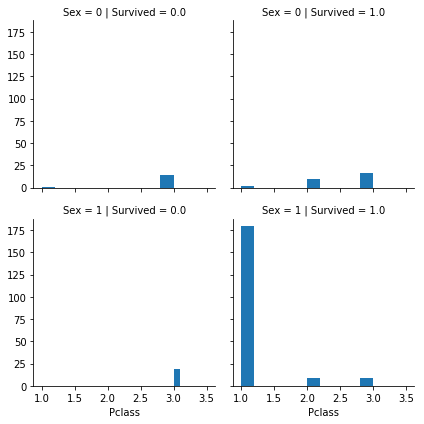

In [292]:
sns.FacetGrid(df[(df["AgeGroup"]==1)|(df["AgeGroup"]==2)],col="Survived",row="Sex").map(plt.hist,"Pclass")

In [316]:
def agepclass(id):
    if ((df.loc[id,"Pclass"]==1)|(df.loc[id,"Pclass"]==2))&(df.loc[id,"Age"]<15):
        return 1
    else:
        return 0

In [318]:
df["agepclass"]=pd.Series(range(0,1309)).apply(agepclass)

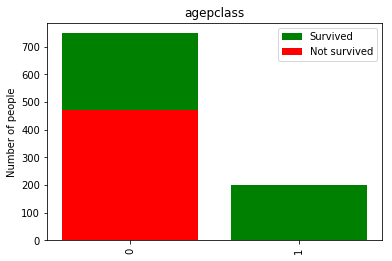

In [320]:
plot(["agepclass"])

#### What we learn
- Children who are male in first or second class also survive.

#### Embarked

In [23]:
df.groupby("Embarked").size()

Embarked
C    270
Q    123
S    914
dtype: int64

Only 2 embarked missing

In [65]:
df["Embarked"]=df["Embarked"].fillna(df["Embarked"].mode()[0])

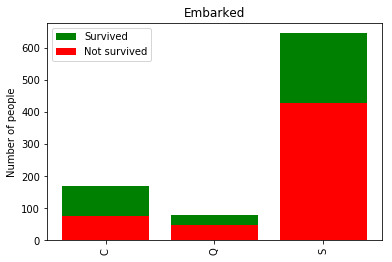

In [68]:
plot(["Embarked"])

#### SibSp

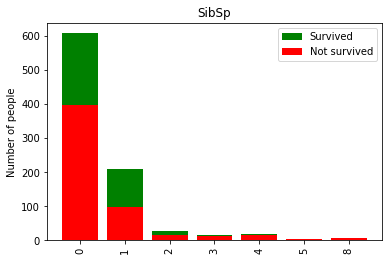

In [69]:
plot(["SibSp"])

#### Parch

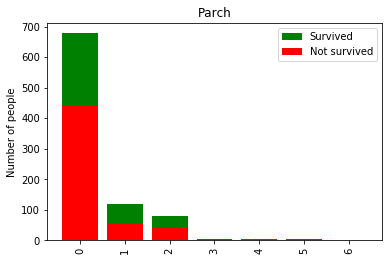

In [70]:
plot(["Parch"])

### Filling missing values

#### Age

Text(0.5,1,'Not Survived')

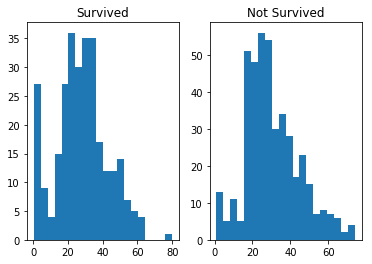

In [83]:
plt.subplot(1,2,1)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=20)
plt.title("Survived")

plt.subplot(1,2,2)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=20)
plt.title("Not Survived")

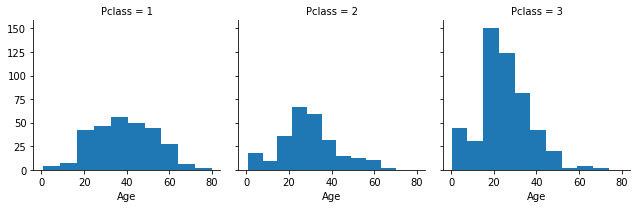

In [84]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Pclass").map(plt.hist,"Age")

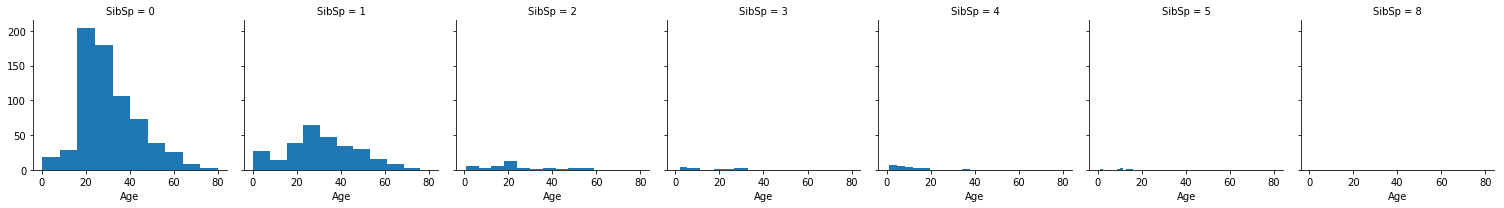

In [85]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="SibSp").map(plt.hist,"Age")

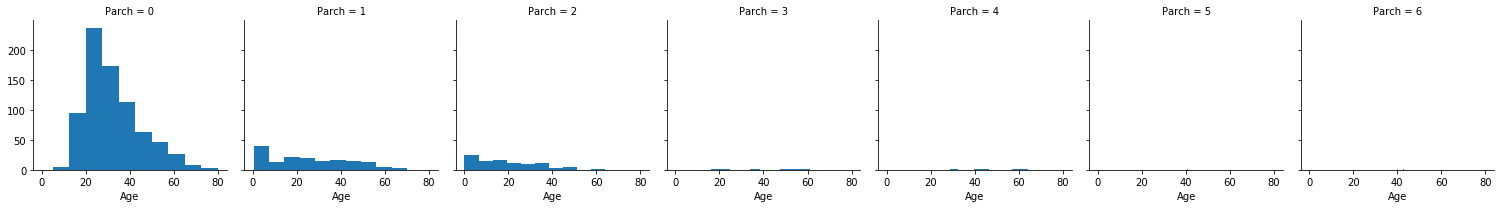

In [86]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Parch").map(plt.hist,"Age")

In [87]:
index_age=df[df["Age"].isnull()].index.values
median=df["Age"][df["Age"].notnull()].median()
for i in index_age: 
    Pclass,Parch,SibSp=df.loc[i,"Pclass"],df.loc[i,"Parch"],df.loc[i,"SibSp"]
    subset=df["Age"][(df["Pclass"]==Pclass)&(df["Parch"]==Parch)&(df["SibSp"]==SibSp)]
    if subset.any():
        median_s=int(subset.median())
        df.loc[i,"Age"]=median_s
    else:
        df.loc[i,"Age"]=median   

### Feature engineering

#### Deck

In [88]:
def find_deck(cabin):
    try:
        match=re.search(r'[A-Z]',str(cabin))
        return match.group()
    except AttributeError:
        return 0

In [89]:
df["Deck"]=df["Cabin"].apply(find_deck)   

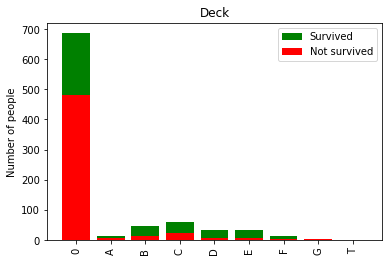

In [90]:
plot(["Deck"])

#### DeckKnown

In [91]:
df["DeckKnown"]=df["Deck"].apply(lambda x: 1 if x else 0)

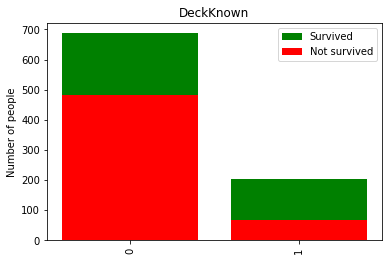

In [92]:
plot(["DeckKnown"])

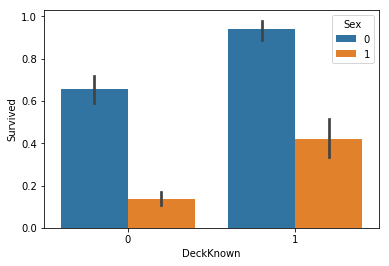

In [110]:
sns.barplot(x="DeckKnown",y="Survived",hue="Sex",data=df)

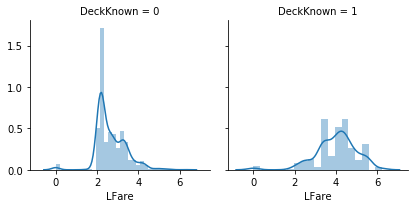

In [227]:
sns.FacetGrid(col="DeckKnown",data=df).map(sns.distplot,"LFare")

#### Survivors on same ticket

In [93]:
def survivors_ticket(index):
    ticketnr=df.loc[index,"Ticket"]
    temp=df[df["Ticket"]==ticketnr]
    if index<=890:
        survived=temp["Survived"].sum()-df.loc[index,"Survived"]
    else:
        survived=temp["Survived"].sum()
    return survived

In [94]:
df["SurvivorsTicket"]=pd.Series(df.index).apply(survivors_ticket)

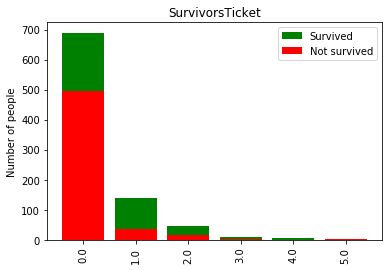

In [95]:
plot(["SurvivorsTicket"])

In [111]:
df["Stick2"]=df["SurvivorsTicket"].apply(lambda x: round(x/(x+1)))

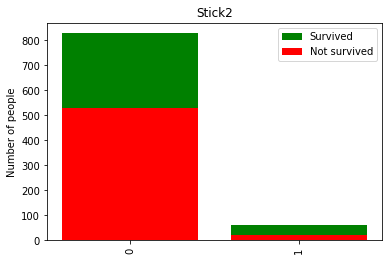

In [112]:
plot(["Stick2"])

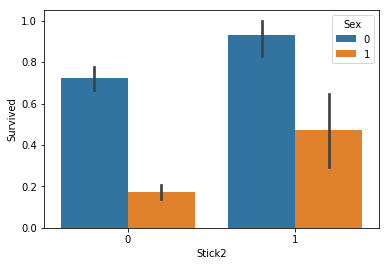

In [113]:
sns.barplot(x="Stick2",y="Survived",hue="Sex",data=df)

#### Title

In [114]:
def find_title(name):
    match=re.search(r",\s[A-Za-z]+",str(name))
    return match.group()[2:]

In [115]:
df["Title"]=df["Name"].apply(find_title)
df["Title"]=df["Title"].replace(["Capt","Col","Don","Dr","Jonkheer","Lady","Major",
                                 "Mlle","Mme","Ms","Rev","Sir","the","Dona"],"rare")

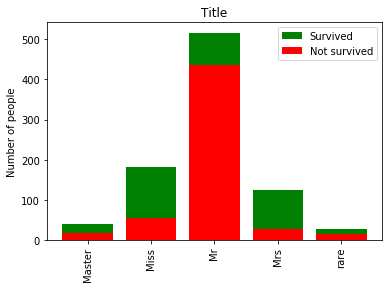

In [116]:
plot(["Title"])

#### Family Size

In [117]:
df["Size"]=df["SibSp"]+df["Parch"]

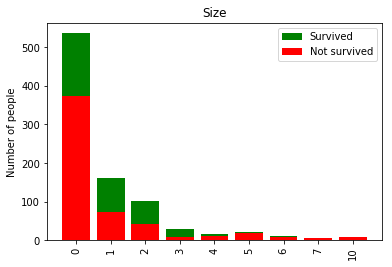

In [118]:
plot(["Size"])

In [119]:
def family_size(size):
    if size==0:
        return "Single"
    if (size>=1) & (size<=3):
        return "Small"
    if size>=4:
        return "Large"

In [120]:
df["FSize"]=df["Size"].apply(family_size)

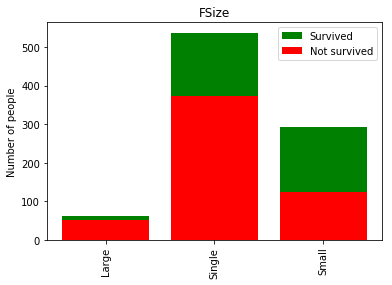

In [121]:
plot(["FSize"])

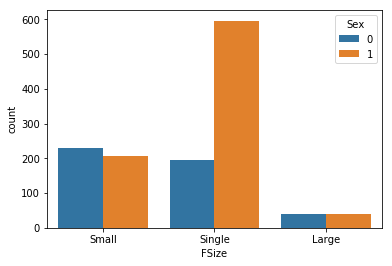

In [163]:
sns.countplot(x="FSize",hue="Sex",data=df)

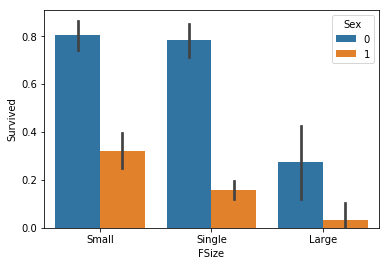

In [123]:
sns.barplot(x="FSize",y="Survived",hue="Sex",data=df)

#### Correlation

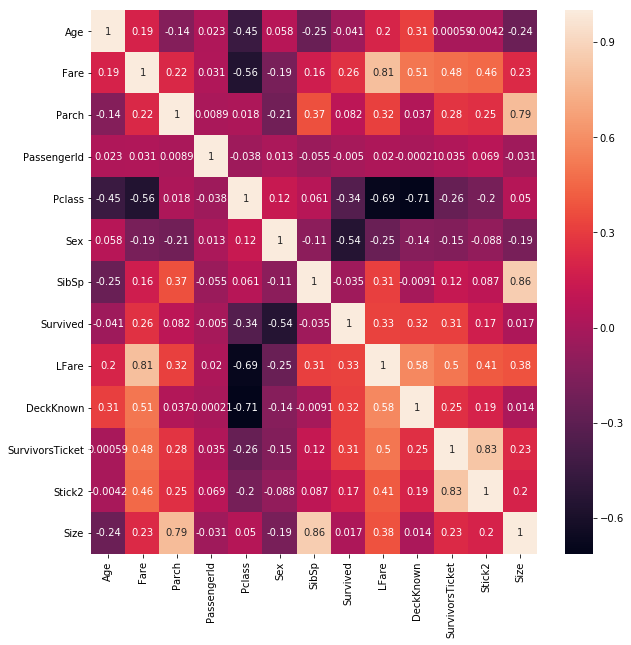

In [127]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

#### Get dummies

In [339]:
df_dummies=pd.get_dummies(df,columns=["PSex","Pclass","FSize","Title","AgeGroup","Embarked"])

In [340]:
df_dummies.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,LFare,rLFare,Deck,DeckKnown,SurvivorsTicket,Stick2,Size,agepclass,PSex_1,PSex_2,...,FSize_1,FSize_Large,FSize_Single,FSize_Small,Title_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_rare,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,AgeGroup_6,Embarked_1,Embarked_C,Embarked_Q,Embarked_S
0,22.000,NaN,7.250,"Braund, Mr. Owen Harris",0,1,1,1,0.000,A/5 21171,2.110,1,0,0,0.000,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,38.000,C85,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.000,PC 17599,4.281,3,C,1,0.000,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,26.000,NaN,7.925,"Heikkinen, Miss. Laina",0,3,0,0,1.000,STON/O2. 3101282,2.189,1,0,0,0.000,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,35.000,C123,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.000,113803,3.991,2,C,1,0.000,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,35.000,NaN,8.050,"Allen, Mr. William Henry",0,5,1,0,0.000,373450,2.203,1,0,0,0.000,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


### Machine learning

I split my data into 3 partitions. Training set, test set and real test set. I also use cv on training set. 

In [325]:
X_full=df_dummies.drop(labels=["Survived"],axis=1)[:len(train)]
y_full=df_dummies["Survived"][:len(train)]
test=df_dummies.drop(labels=["Survived"],axis=1)[len(train):]

In [326]:
X_train,X_test,y_train,y_test=train_test_split(X_full,y_full,test_size=0.25,shuffle=True,random_state=42)

After inspection, the dataframes seem similar

#### Cross-validation

In [327]:
clfs=[DecisionTreeClassifier(),SVC(),AdaBoostClassifier(),RandomForestClassifier(),KNeighborsClassifier(),GaussianNB(),
      XGBClassifier(),LogisticRegression(),
      VotingClassifier(estimators=[("xgb",XGBClassifier()),("svm",SVC()),("lr",LogisticRegression())
                                  ,("ada",AdaBoostClassifier()),("rf",RandomForestClassifier())])]

In [328]:
kfold=RepeatedStratifiedKFold(n_splits=5,n_repeats=1,random_state=42)

In [329]:
features=["Sex"]

In [330]:
def cross_validate(X_train=X_train,y_train=y_train,clfs=clfs,features=features,kfold=kfold,vis=True,table=True):
    outcomes={}
    names=[]
    mean_accuracy=[]
    std=[]
    for c in clfs: 
        name=c.__class__.__name__
        names.append(name)
        outcomes[name]=cross_val_score(c,X_train[features],y_train,cv=kfold,scoring="accuracy",verbose=0)
        mean_accuracy.append(outcomes[name].mean())
        std.append(outcomes[name].std())
    clf_results=pd.DataFrame({"Classifier":names,"Mean accuracy":mean_accuracy,"Standard Deviation":std})
    print ("features:" + str(features))
    if table:
        display(clf_results)
    if vis:
        plt.bar(np.arange(len(clf_results)),clf_results["Mean accuracy"],yerr=clf_results["Standard Deviation"])
        plt.xticks(np.arange(len(clf_results)),clf_results["Classifier"],rotation=90)
        plt.show()      

In [356]:
features=["PSex_1","PSex_2","PSex_3","PSex_4","PSex_5","PSex_6",
           "agepclass",
          "LFare"         
          ]

features:['PSex_1', 'PSex_2', 'PSex_3', 'PSex_4', 'PSex_5', 'PSex_6', 'agepclass', 'LFare']


,Classifier,Mean accuracy,Standard Deviation
0,DecisionTreeClassifier,0.873,0.020
1,SVC,0.841,0.017
2,AdaBoostClassifier,0.868,0.026
3,RandomForestClassifier,0.871,0.013
4,KNeighborsClassifier,0.870,0.028
5,GaussianNB,0.846,0.025
6,XGBClassifier,0.882,0.022
7,LogisticRegression,0.825,0.024
8,VotingClassifier,0.873,0.017


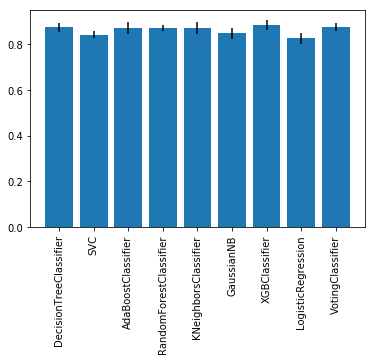

In [357]:
cross_validate(features=features)

### Check on test set

In [361]:
xgb=XGBClassifier()
xgb.fit(X_train[features],y_train)
pred=xgb.predict(X_test[features])
accuracy_score(y_test,pred)

0.8878923766816144

### Parameter tuning

In [362]:
tuning_results={}

In [370]:
def do_tune(clf_single,parameters):
    clf=GridSearchCV(clf_single,parameters,cv=kfold,scoring="accuracy",verbose=1,n_jobs=-1)
    clf.fit(X_full[features],y_full)
    name=clf_single.__class__.__name__
    tuning_results[name]=[clf.best_score_,clf.best_params_,clf.best_estimator_]
    return

In [371]:
parameters_AB={"learning_rate":[0.1,0.2,0.4,1],"n_estimators":[50],"base_estimator":[DecisionTreeClassifier()],"algorithm":\
              ["SAMME","SAMME.R"]}
parameters_RF = {"max_depth": [None],"max_features": [1, 3, 10],"min_samples_split": [2, 3, 10],"min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],"n_estimators" :[100,300],"criterion": ["gini"]}
parameters_logr={"C":[0.001,0.01,0.1,1,10,100,1000]}
parameters_xgb={"max_depth":[3,5,6,7,9,11,13,17,20],"learning_rate":[0.001,0.01,0.1]}


In [372]:
do_tune(xgb,parameters_xgb)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   48.7s finished


In [373]:
results,keys,clf_best=[],[],[]
for k in tuning_results.keys():
    keys.append(k)
    results.append(tuning_results[k][0])   
    clf_best.append(tuning_results[k][2])

In [374]:
pd.DataFrame({"name":keys,"tuned accuracy":results})

,name,tuned accuracy
0,XGBClassifier,0.892


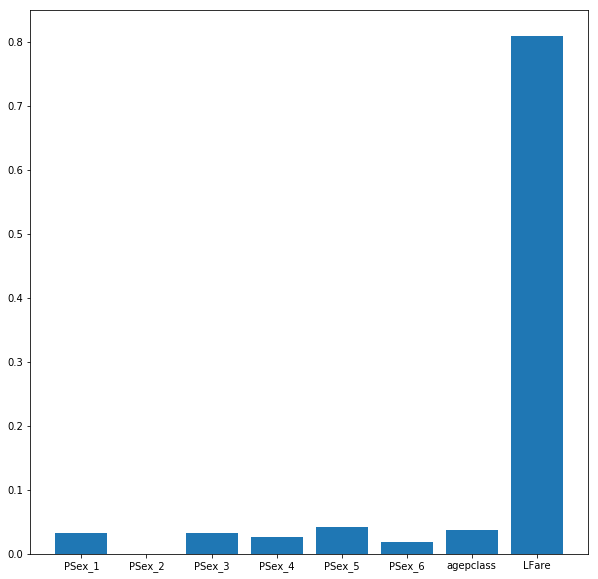

In [383]:
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(X_full[features].columns)),tuning_results["XGBClassifier"][2].feature_importances_)
plt.xticks(np.arange(len(X_full[features].columns)),X_full[features])
plt.show()

In [384]:
clf_best

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1)]

In [386]:
pred_xgb=clf_best[0].predict(test[features])

### Output

In [387]:
submission=pd.concat([testId,pd.Series(pred_xgb).astype(int)],axis=1)

In [389]:
submission.columns=["PassengerId","Survived"]

In [391]:
submission.to_csv("ThirdSubmission.csv",index=False)

In [390]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


PL score is 0.775 while CV score is 0.845. 

In [152]:
from scipy.stats import binom

In [171]:
binom.cdf(155,200,0.845)

0.005754998110640135